In [1]:
push!(LOAD_PATH, "../src")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"      
 "../src"                                                          

In [2]:
using Ensemble
using Gadfly

Now we define some priors and likelihoods.  First, the prior, which we take to be uniform in $[0,1]$.  However, for sampling efficiency, we transform $[0,1]$ to $[-\infty, \infty]$ using the logit transform.  If we write $y = \mathrm{logit}(x)$, with $p(x) = 1$, then 
$$
p(y) = \frac{p(x)}{dy/dx} = \frac{1}{\frac{1}{x} + \frac{1}{1-x}} = x(1-x) = \frac{e^y}{\left(1 + e^y\right)^2}
$$

In [3]:
function logp(y)
    if y < zero(y)
        y - 2.0*log1p(exp(y))
    else
        -y - 2.0*log1p(exp(-y))
    end
end

function logp(y::Array{Float64,1})
    logp(y[1])
end

logp (generic function with 2 methods)

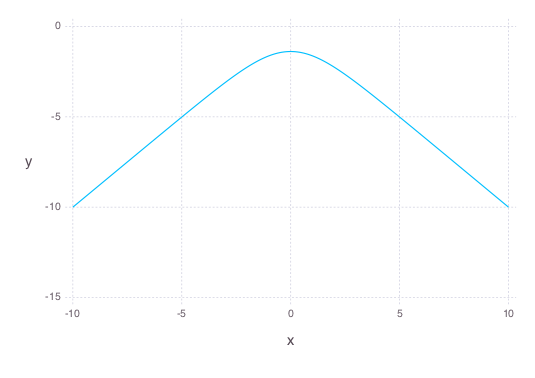

In [4]:
ys = collect(-10:0.1:10)
plot(x=ys, y=[logp(y) for y in ys], Geom.line)

And the likelihood is N(0.5, 0.01):

In [5]:
function logl(y)
    sigma = 0.01
    mu = 0.5
    
    ey = exp(y)
    x = ey / (one(ey) + ey)
    
    -0.5*log(2.0*pi) - log(sigma) - 0.5*(x-mu)*(x-mu)/(sigma*sigma)
end

function logl(y::Array{Float64, 1})
    logl(y[1])
end

logl (generic function with 2 methods)

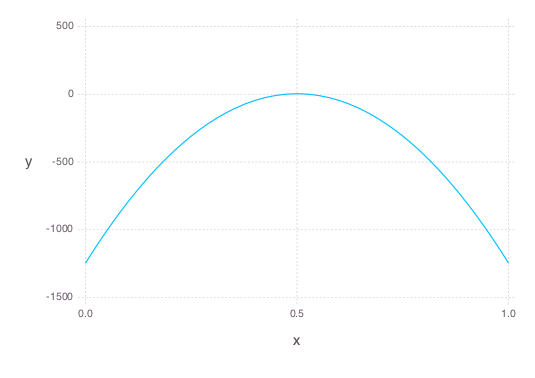

In [6]:
plot(x=exp(ys)./(1.0+exp(ys)), y=[logl(y) for y in ys], Geom.line)

Now we set up and run nested sampling:

In [48]:
xs = rand((1, 512))
ys = log(xs) - log(1-xs)
ns = Ensemble.EnsembleNest.NestState(logl, logp, ys, 100)

Ensemble.EnsembleNest.NestState(logl,logp,100,1x512 Array{Float64,2}:
 -0.0544907  0.0588271  0.0782771  1.36352  …  -0.034393  -1.91519  1.37197,[-1.38704,-1.38716,-1.38783,-1.819,-1.44302,-1.38757,-1.93052,-2.4949,-2.37916,-1.38858  …  -1.56729,-1.59481,-2.13851,-2.46626,-1.50271,-2.82763,-1.62848,-1.38659,-2.19004,-1.82402],[2.7588,2.60541,1.7734,-435.373,-65.2443,2.09852,-520.949,-833.791,-783.172,0.826566  …  -203.264,-231.583,-657.163,-821.807,-133.683,-950.549,-265.173,3.31665,-686.751,-439.435],1x0 Array{Float64,2},Float64[],Float64[],0.0,-Inf)

In [49]:
Ensemble.EnsembleNest.run!(ns, 1e-3)

In [50]:
post = Ensemble.EnsembleNest.postsample(ns)
println(size(post,2))
post = reshape(post, (size(post, 2),))
post = exp(post)./(1.0 + exp(post)) # Convert back to [0,1]

1058


1058-element Array{Float64,1}:
 0.538967
 0.532863
 0.467248
 0.467431
 0.530977
 0.529142
 0.471208
 0.472585
 0.472743
 0.526953
 0.473726
 0.474208
 0.474249
 ⋮       
 0.500032
 0.499719
 0.500195
 0.499162
 0.499758
 0.500228
 0.500802
 0.500821
 0.499651
 0.500623
 0.499372
 0.500452

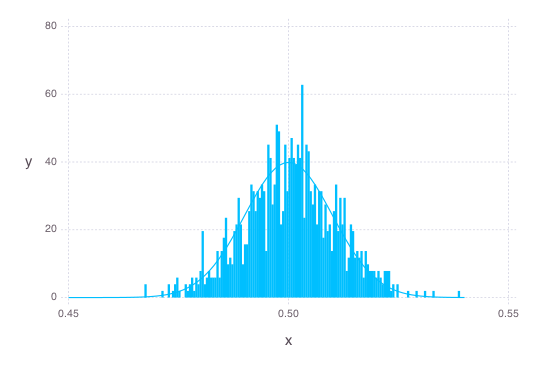

In [51]:
xs = collect(0.45:0.001:0.54)
plot(layer(x=post, Geom.histogram(density=true, )), layer(x=xs, y=1.0/sqrt(2*pi)/0.01*exp(-0.5*(xs-0.5).*(xs-0.5)/0.01/0.01), Geom.line))

In [52]:
Ensemble.EnsembleNest.logZ(ns), Ensemble.EnsembleNest.logdZ(ns)

(-0.032204494473650216,-7.232565174840966)

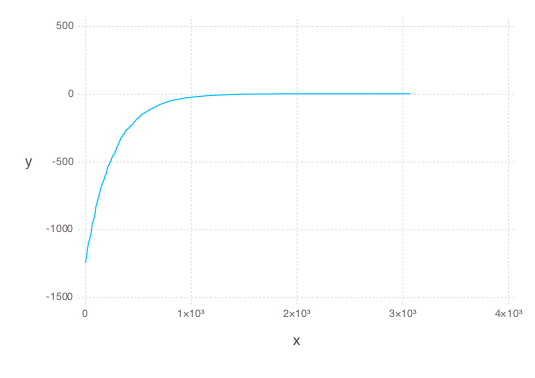

In [53]:
plot(x=1:size(ns.deadpts, 2), y=ns.deadlogls, Geom.line)

In [54]:
mean(randn((10,10)), (1,))

1x10 Array{Float64,2}:
 -0.133954  0.0981253  -0.531692  …  -0.415213  0.350944  -0.118307